#**Room Light Monitoring System using Z-Score**
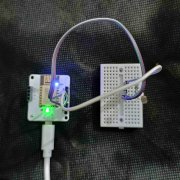 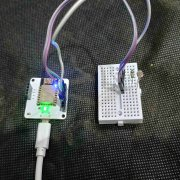

##**Things used in this project**
**Hardware components**
 * Bolt IoT Bolt WiFi Module
 * LDR ( Light Dependent Resistor ) sensor
 * 10k ohm (Brown, Black, Orange) coded Resistor
 * Jumper wires

**Software components**
 * Twilio
 * Python

##**Story**
We all know that plants require sunlight for their healthy growth. However, at times we may not be able to keep a track of it or maybe we are not sure if our plants are getting enough sunlight.

In this project, we will build a system so that we could monitor the light our plants get and send the data to Bolt Cloud. In fact, this product is commercially available by Xiaomi . But as makers, we shall build this product on our own.

##**Gathering all required components**
* Bolt WiFi Module
* LDR ( Light Dependent Resistor ) sensor
* 10k ohm (Brown, Black, Orange) coded Resistor
* Breadboard
* Wires

##**Installing BoltIoT library**

In [1]:
!pip install boltiot

##**Importing required libraries**

In [2]:
import json, time, math, statistics
from boltiot import Sms, Bolt

##**Adding credentials of Bolt Module and Twilio Account**

In [3]:
api_key = "XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX"
device_id = "BOLTXXXXXXX"
mybolt = Bolt(api_key,device_id)

SID = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
auth_token = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
to_number = "+91XXXXXXXXXX"
from_number = "+16XXXXXXXX"
sms = Sms(SID,auth_token,to_number,from_number)

FRAME_SIZE = 10
MUL_FACTOR = 6

In [4]:
split = mybolt.isOnline().split('"')
print(split)

['{', 'value', ': ', 'online', ', ', 'time', ': ', 'Thu 2024-08-22 05:47:14 UTC', ', ', 'success', ': 1}']


In [16]:
def compute_bounds( history_data, frame_size, factor ):
    if (len(history_data)<frame_size) :
        return None
    if (len(history_data)>frame_size) :
        del history_data[0:len(history_data)-frame_size]
    mean = statistics.mean(history_data)
    variance = 0
    for data in history_data :
        variance += math.pow( (data-mean) , 2)
    Zn = factor * math.sqrt(variance/frame_size)
    High_bound = history_data[frame_size-1]+Zn
    Low_bound = history_data[frame_size-1]-Zn
    return [High_bound,Low_bound]

##**Light Intensity Monitoring Code**

In [18]:
if( split[3]=="offline" ):
    print("Bolt is offline. Please check connections")
    exit()
else:
  history_data = [ ]
  while (True):
    response = mybolt.analogRead('A0')
    data = json.loads(response)
    current_time = time.asctime().split(' ')[3]
    if (data['success']) != 1:
        print("There was an error while retriving the data.")
        print("This is the error:"+data['value'])

        continue

    print ("This is the value "+data['value'])
    sensor_value=0
    try:
        sensor_value = int(data['value'])
    except e:
        print("There was an error while parsing the response: ",e)
        continue

    bound = compute_bounds(history_data,FRAME_SIZE, MUL_FACTOR)
    if not bound:
        required_data_count = FRAME_SIZE-len( history_data )
        print("Not enough data to compute Z-score. Need ",required_data_count," more data points")
        history_data.append( int(data['value']) )

        continue

    try:
        if (sensor_value > bound[0]) :
            print ("The light level increased suddenly. Sending an SMS.")
            response = sms.send_sms("Someone turned on the lights")
            print("This is the response ",response)
        elif (sensor_value < bound[1]):
            print ("The light level decreased suddenly. Sending an SMS.")
            response = sms.send_sms("Someone turned off the lights")
            print("This is the response ",response)
        history_data.append( int(data['value']) );
    except Exception as e:
        print ("Error",e)


This is the value 1024
Not enough data to compute Z-score. Need  10  more data points
This is the value 1024
Not enough data to compute Z-score. Need  9  more data points
This is the value 1024
Not enough data to compute Z-score. Need  8  more data points
This is the value 1024
Not enough data to compute Z-score. Need  7  more data points
This is the value 1024
Not enough data to compute Z-score. Need  6  more data points
This is the value 1024
Not enough data to compute Z-score. Need  5  more data points
This is the value 1024
Not enough data to compute Z-score. Need  4  more data points
This is the value 1024
Not enough data to compute Z-score. Need  3  more data points
This is the value 1024
Not enough data to compute Z-score. Need  2  more data points
This is the value 1024
Not enough data to compute Z-score. Need  1  more data points
This is the value 1024
This is the value 1024
This is the value 1024
This is the value 1024
This is the value 1024
This is the value 1024
This is the

##**Readings from sensor**

In [19]:
print(history_data)

[1024, 1024, 1024, 1024, 1024, 1024, 145, 38, 41, 1024, 1024]


##**Table of Light Intensity**

In [20]:
import pandas as pd
df = pd.DataFrame(history_data,columns=['Light Intensity'])
df

,Light Intensity
0,1024
1,1024
2,1024
3,1024
4,1024
5,1024
6,145
7,38
8,41
9,1024


##**Plotting the graph**

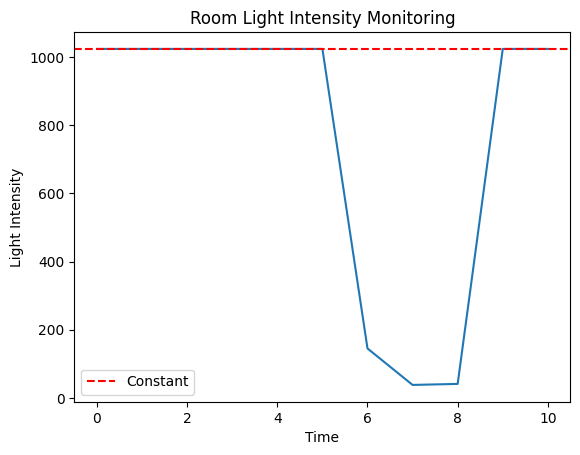

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_data)

plt.axhline( y = 1024, color = 'r', linestyle = '--', label = 'Constant' )

plt.xlabel('Time')
plt.ylabel('Light Intensity')
plt.title('Room Light Intensity Monitoring')
plt.legend()

plt.show()

##**Alert on phone through SMS for light intensity (sensor value) greater and less than maximum and minimum intensity (sensor value)**

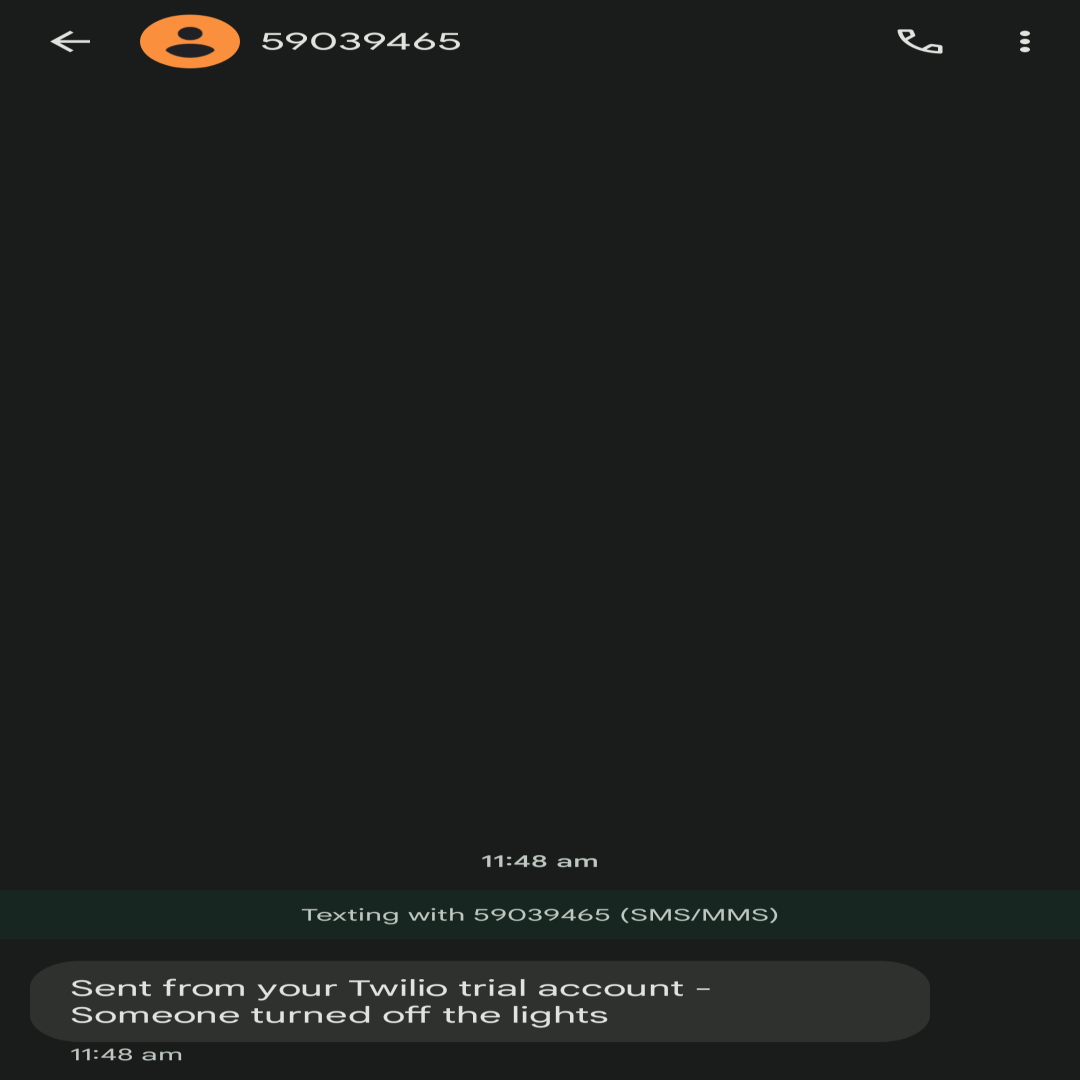